In [18]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import keras
import keras.layers as layers
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.metrics import confusion_matrix

In [19]:
DataSolarModules = pd.read_json('InfraredSolarModules/module_metadata.json').transpose().sort_index()
DataSolarModulesVAE = pd.read_json('InfraredSolarModules/VAE_metadata.json').transpose().sort_index()
Classes = DataSolarModules['anomaly_class'].unique()
class_to_number = dict(enumerate(Classes.flatten(), 0))
class_to_number = {v: k for k, v in class_to_number.items()}

In [20]:
def map_to_class(value):
    class_to_number
    return class_to_number.get(value, 'Unknown')

DataSolarModules['class_code'] = DataSolarModules['anomaly_class'].apply(map_to_class)
DataSolarModulesVAE['class_code'] = DataSolarModulesVAE['anomaly_class'].apply(map_to_class)

In [21]:
def read_images_dataframe(dataframe):
    images = []
    for image_path in dataframe['image_filepath']:
        img = cv2.imread("InfraredSolarModules/"+image_path,cv2.IMREAD_GRAYSCALE)
        img = img.reshape(40, 24).astype("float32") / 255
        images.append(img)
    images=np.array(images) 
    return images

def read_labels_dataframe(dataframe):
    labels = []
    for label in dataframe['class_code']:
        labels.append(label)
    labels=np.array(labels) 
    labels.astype("int32")   
    return labels

In [22]:
images = read_images_dataframe(DataSolarModules)
imagesVAE = read_images_dataframe(DataSolarModulesVAE)
labels = read_labels_dataframe(DataSolarModules)
labelsVAE = read_labels_dataframe(DataSolarModulesVAE)

In [23]:
images = np.concatenate((images, imagesVAE), axis=0)
labels = np.concatenate((labels, labelsVAE), axis=0)

In [24]:
inputs = keras.Input(shape=(40, 24, 1))


x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)

x = layers.Flatten()(x)

x = layers.Dense(2048, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(128, activation="relu")(x)


outputs = layers.Dense(12, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 40, 24, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 38, 22, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 19, 11, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 17, 9, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 2, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 2048)           │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,386,956 (16.73 MB)

 Trainable params: 4,386,956 (16.73 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
batch_size = 64
n_epochs = 25

optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

rkf = RepeatedKFold(n_splits=6, n_repeats=3, random_state=21312312)
datos = list(range(0,len(images)))

data_train, data_test = train_test_split(datos, test_size=0.2)


model.compile(optimizer=optimizer,                                    
              loss="sparse_categorical_crossentropy",                 
              metrics=["accuracy"])   

In [26]:
fold_no = 1
acc_per_fold = []
loss_per_fold = []

all_train_losses = []
all_train_accuracies = []
all_val_losses = []
all_val_accuracies = []

for train, val in rkf.split(data_train):

    history_model = model.fit(images[train], labels[train],
                              epochs=n_epochs,
                              validation_data=(images[val], labels[val]),
                              batch_size=batch_size)

    # Store metrics for this fold
    fold_train_loss = np.mean(history_model.history['loss'])
    fold_train_accuracy = np.mean(history_model.history['accuracy'])
    fold_val_loss = np.mean(history_model.history['val_loss'])
    fold_val_accuracy = np.mean(history_model.history['val_accuracy'])

    all_train_losses.append(fold_train_loss)
    all_train_accuracies.append(fold_train_accuracy)
    all_val_losses.append(fold_val_loss)
    all_val_accuracies.append(fold_val_accuracy)

    # Generate generalization metrics for the last epoch
    scores = model.evaluate(images[val], labels[val],verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1] * 100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no += 1

Epoch 1/25


I0000 00:00:1716620259.465040   34446 service.cc:145] XLA service 0x73ce5c0025d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716620259.465063   34446 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2024-05-25 14:57:39.499631: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-25 14:57:39.689333: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


109/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4190 - loss: 2.0382

I0000 00:00:1716620264.049148   34446 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4291 - loss: 1.9667

I0000 00:00:1716620280.432948   34710 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1716620280.485424   34700 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1716620280.606514   34712 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 308 bytes spill stores, 308 bytes spill loads

I0000 00:00:1716620283.035547   34817 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 264 bytes spill stores, 264 bytes spill loads

I0000 00:00:1716620283.112810   34814 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 260 bytes spill stores, 260 bytes spill loads

I0000 00:00:1716620283.230470 

299/299 ━━━━━━━━━━━━━━━━━━━━ 26s 67ms/step - accuracy: 0.4291 - loss: 1.9664 - val_accuracy: 0.4245 - val_loss: 1.8466
Epoch 2/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4527 - loss: 1.7699 - val_accuracy: 0.5465 - val_loss: 1.4779
Epoch 3/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5579 - loss: 1.4611 - val_accuracy: 0.5478 - val_loss: 1.4394
Epoch 4/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5863 - loss: 1.3103 - val_accuracy: 0.5879 - val_loss: 1.2905
Epoch 5/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6104 - loss: 1.2241 - val_accuracy: 0.6384 - val_loss: 1.1041
Epoch 6/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6322 - loss: 1.1348 - val_accuracy: 0.6512 - val_loss: 1.0627
Epoch 7/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6491 - loss: 1.0935 - val_accuracy: 0.6633 - val_loss: 1.0407
Epoch 8/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6567 - loss: 1.0370 - val_accuracy: 0.6510 - va

I0000 00:00:1716620295.694681   36325 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1716620295.731001   36310 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1716620295.818152   36329 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1716620297.361661   36448 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_103', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1716620297.482971   36442 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 8 bytes spill stores, 16 bytes spill loads



Score for fold 1: loss of 0.7460789084434509; compile_metrics of 77.48101353645325%
Epoch 1/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8059 - loss: 0.6107 - val_accuracy: 0.8442 - val_loss: 0.4664
Epoch 2/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8155 - loss: 0.5740 - val_accuracy: 0.8353 - val_loss: 0.4922
Epoch 3/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8112 - loss: 0.5831 - val_accuracy: 0.8429 - val_loss: 0.4650
Epoch 4/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8176 - loss: 0.5375 - val_accuracy: 0.8521 - val_loss: 0.4422
Epoch 5/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8301 - loss: 0.5187 - val_accuracy: 0.8434 - val_loss: 0.4737
Epoch 6/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8303 - loss: 0.4995 - val_accuracy: 0.8191 - val_loss: 0.5599
Epoch 7/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8382 - loss: 0.4990 - val_accuracy: 0.8400 - val_loss: 0.4759
Epoch 8/25
299/299 ━

I0000 00:00:1716620350.995641   40949 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 260 bytes spill stores, 260 bytes spill loads

I0000 00:00:1716620351.034691   40947 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 308 bytes spill stores, 308 bytes spill loads

I0000 00:00:1716620351.069372   40942 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 264 bytes spill stores, 264 bytes spill loads



299/299 ━━━━━━━━━━━━━━━━━━━━ 19s 63ms/step - accuracy: 0.9312 - loss: 0.2243 - val_accuracy: 0.9861 - val_loss: 0.0571
Epoch 2/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9393 - loss: 0.1951 - val_accuracy: 0.9835 - val_loss: 0.0650
Epoch 3/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9449 - loss: 0.1733 - val_accuracy: 0.9699 - val_loss: 0.0982
Epoch 4/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9345 - loss: 0.2088 - val_accuracy: 0.9741 - val_loss: 0.0827
Epoch 5/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9433 - loss: 0.1802 - val_accuracy: 0.9749 - val_loss: 0.0762
Epoch 6/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9516 - loss: 0.1556 - val_accuracy: 0.9767 - val_loss: 0.0743
Epoch 7/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9467 - loss: 0.1726 - val_accuracy: 0.9738 - val_loss: 0.0948
Epoch 8/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9443 - loss: 0.1797 - val_accuracy: 0.9725 - va

I0000 00:00:1716620363.114347   42434 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_103', 8 bytes spill stores, 8 bytes spill loads



Score for fold 5: loss of 0.1437278687953949; compile_metrics of 94.94499564170837%
Epoch 1/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9444 - loss: 0.1888 - val_accuracy: 0.9869 - val_loss: 0.0445
Epoch 2/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9514 - loss: 0.1605 - val_accuracy: 0.9924 - val_loss: 0.0295
Epoch 3/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9550 - loss: 0.1521 - val_accuracy: 0.9827 - val_loss: 0.0613
Epoch 4/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9560 - loss: 0.1395 - val_accuracy: 0.9822 - val_loss: 0.0628
Epoch 5/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9505 - loss: 0.1610 - val_accuracy: 0.9866 - val_loss: 0.0460
Epoch 6/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9574 - loss: 0.1346 - val_accuracy: 0.9900 - val_loss: 0.0388
Epoch 7/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9616 - loss: 0.1214 - val_accuracy: 0.9793 - val_loss: 0.0711
Epoch 8/25
299/299 ━

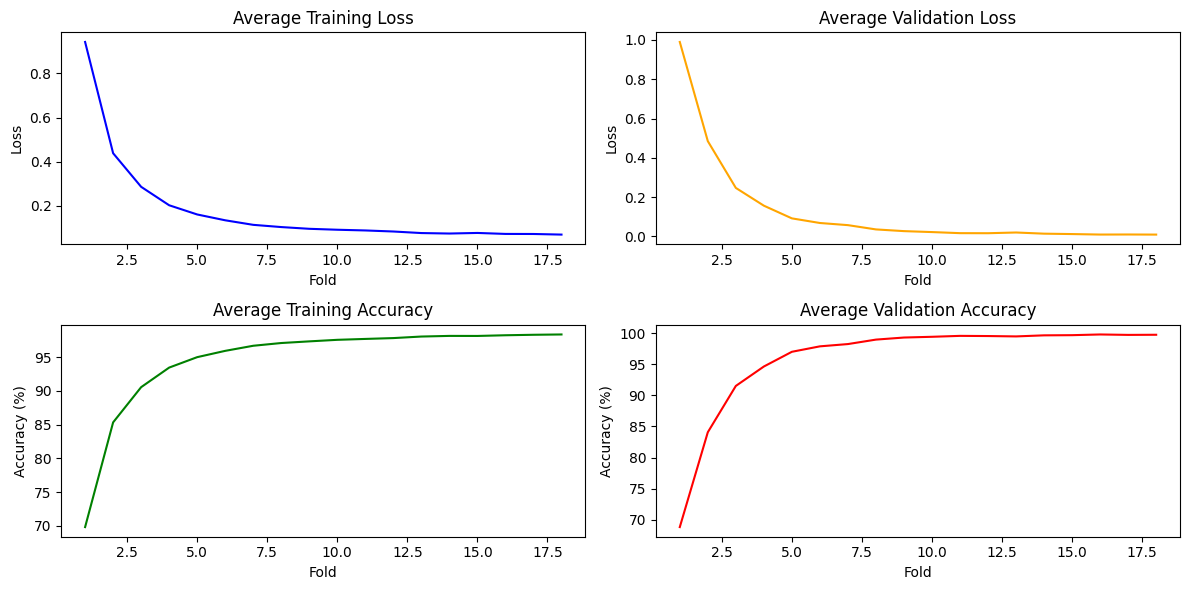

In [27]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(range(1, len(all_train_losses) + 1), all_train_losses, color='blue')
plt.title('Average Training Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')

plt.subplot(2, 2, 2)
plt.plot(range(1, len(all_val_losses) + 1), all_val_losses, color='orange')
plt.title('Average Validation Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')

plt.subplot(2, 2, 3)
plt.plot(range(1, len(all_train_accuracies) + 1), [acc * 100 for acc in all_train_accuracies], color='green')
plt.title('Average Training Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')

plt.subplot(2, 2, 4)
plt.plot(range(1, len(all_val_accuracies) + 1), [acc * 100 for acc in all_val_accuracies], color='red')
plt.title('Average Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

In [28]:
test_metrics = model.evaluate(images[data_test], labels[data_test])  
print("Test loss:", test_metrics[0])
print("Test accuracy:", test_metrics[1])

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9936 - loss: 0.0340
Test loss: 0.02965160459280014
Test accuracy: 0.9930179715156555


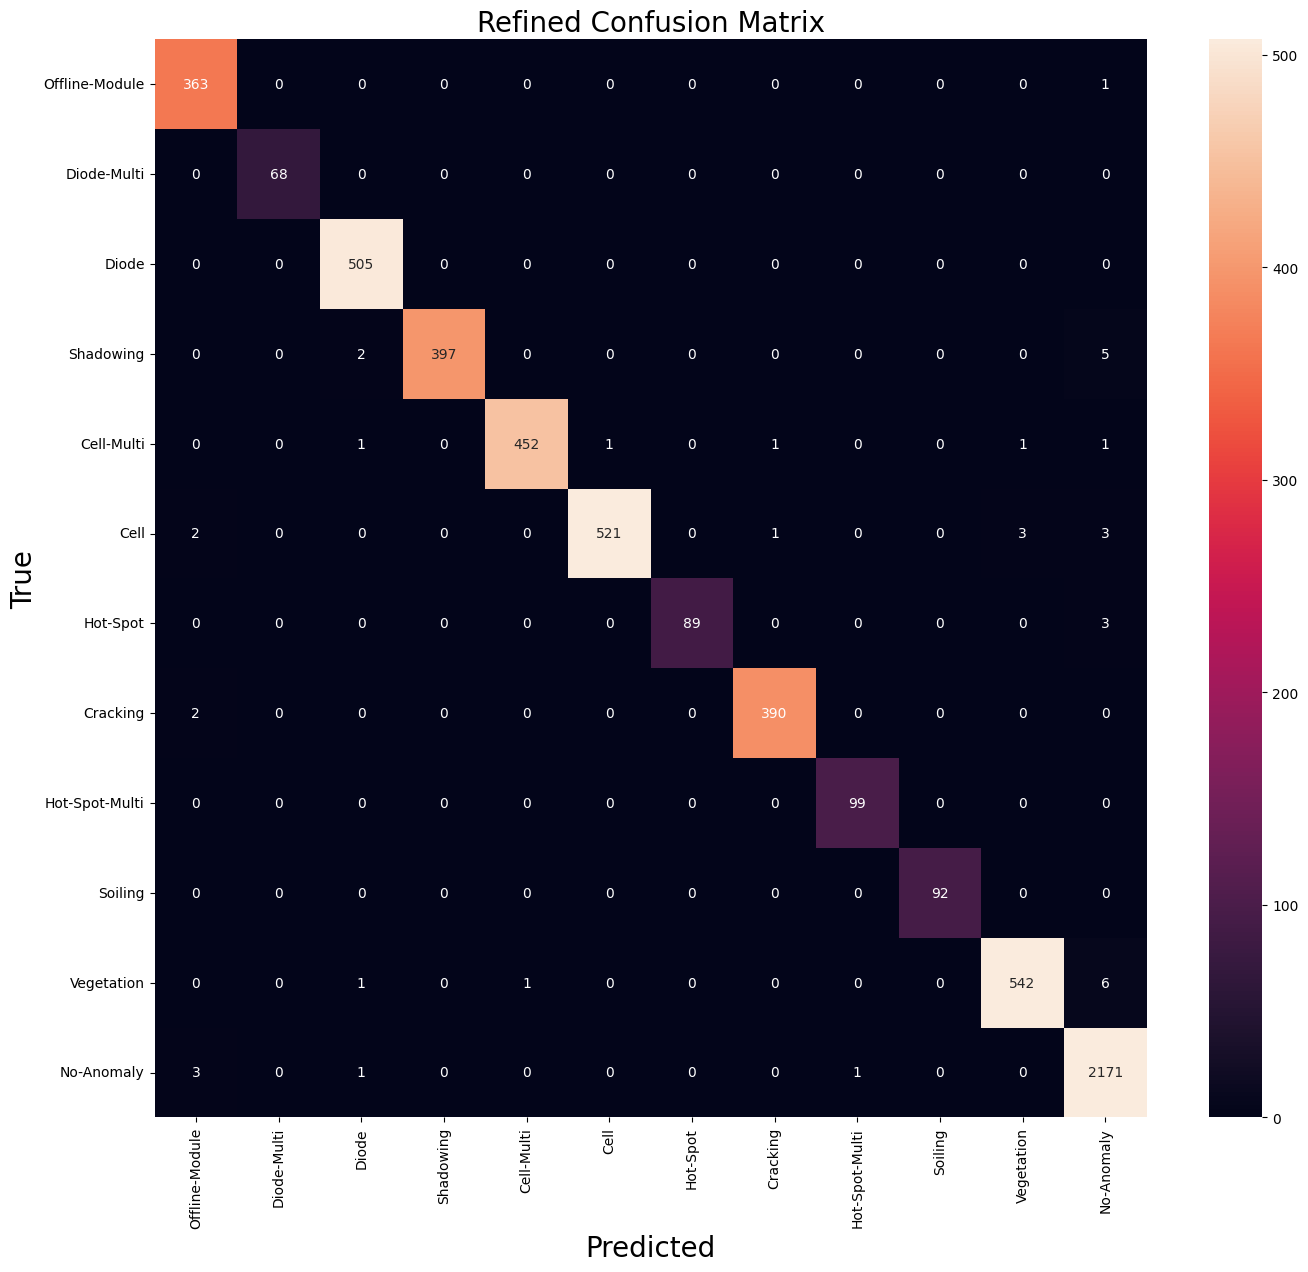

In [29]:
### Confusion Matrix
predictions = model.predict(images[data_test], steps=len(data_test), verbose=0)

y_pred = np.argmax(predictions, axis=-1)

cm = confusion_matrix(labels[data_test], y_pred)

## Get Class Labels
class_names = Classes

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True,robust=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

plt.show()

In [30]:
tp_and_fn = cm.sum(1)
tp_and_fp = cm.sum(0)
tp = cm.diagonal()
accuracy = cm.diagonal().sum()/cm.sum()
precision = tp / tp_and_fp
recall = tp / tp_and_fn
f1 = 2 * (precision * recall) / (precision + recall)
precision_avg=np.average(precision)
recall_avg=np.average(recall)
f1_avg=np.average(f1)

In [31]:
# Creating a dictionary with the data
data = {
    'Metrics': ['Accuracy', 'Average Precision', 'Average Recall', 'Average F1 Score'],
    'Values': [accuracy, precision_avg, recall_avg, f1_avg]
}

# Creating the DataFrame
df = pd.DataFrame(data)

# Displaying the DataFrame
print(df)

             Metrics    Values
0           Accuracy  0.993018
1  Average Precision  0.994671
2     Average Recall  0.991454
3   Average F1 Score  0.993016


In [32]:
data = {
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

# Creating the DataFrame
df = pd.DataFrame(data)

# Displaying the DataFrame
print(df)

             Class  Precision    Recall  F1 Score
0   Offline-Module   0.981081  0.997253  0.989101
1      Diode-Multi   1.000000  1.000000  1.000000
2            Diode   0.990196  1.000000  0.995074
3        Shadowing   1.000000  0.982673  0.991261
4       Cell-Multi   0.997792  0.989059  0.993407
5             Cell   0.998084  0.983019  0.990494
6         Hot-Spot   1.000000  0.967391  0.983425
7         Cracking   0.994898  0.994898  0.994898
8   Hot-Spot-Multi   0.990000  1.000000  0.994975
9          Soiling   1.000000  1.000000  1.000000
10      Vegetation   0.992674  0.985455  0.989051
11      No-Anomaly   0.991324  0.997702  0.994503
